# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from datetime import datetime, timedelta
import re
from collections import Counter
# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer


from textblob import TextBlob # Дает оценку отзыву


import warnings; warnings.simplefilter('ignore')
        
pd.set_option('display.max_rows', 50) 
pd.set_option('display.max_columns', 250)         
# Any results you write to the current directory are saved as output.

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
current_date = pd.to_datetime('03/05/2021')

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_train.describe()

,Ranking,Rating,Number of Reviews
count,40000.000000,40000.000000,37457.000000
mean,3676.028525,3.993037,124.825480
std,3708.749567,0.668417,295.666352
min,1.000000,1.000000,2.000000
25%,973.000000,3.500000,9.000000
50%,2285.000000,4.000000,33.000000
75%,5260.000000,4.500000,115.000000
max,16444.000000,5.000000,9660.000000


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [12]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, поэтому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [14]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
980,id_980,Paris,"['Moroccan', 'Mediterranean']",7724.0,$,29.0,"[['Delicious dinner and a warm welcome', 'A re...",/Restaurant_Review-g187147-d695070-Reviews-A_l...,d695070,0,0.0
17772,id_11239,Paris,"['Moroccan', 'Mediterranean']",11241.0,$$ - $$$,67.0,[['Busy little moroccan restaurant with tasty....,/Restaurant_Review-g187147-d4347059-Reviews-La...,d4347059,1,3.5
45398,id_2031,Amsterdam,NaN,2036.0,NaN,5.0,"[['Best find!'], ['08/31/2017']]",/Restaurant_Review-g188590-d12504057-Reviews-T...,d12504057,1,4.5
10232,id_1239,Rome,"['Italian', 'Seafood', 'Mediterranean', 'Soups...",1240.0,$$ - $$$,302.0,"[['Excellent food & service', 'Delicious food....",/Restaurant_Review-g187791-d4023512-Reviews-Ho...,d4023512,1,4.0
48426,id_5207,Madrid,"['Peruvian', 'Bar', 'European', 'Pub', 'Portug...",5210.0,$$ - $$$,2.0,"[[], []]",/Restaurant_Review-g187514-d12909414-Reviews-E...,d12909414,1,4.0


In [15]:
data.describe()

,Ranking,Number of Reviews,sample,Rating
count,50000.000000,46800.000000,50000.000000,50000.000000
mean,3664.427520,124.471197,0.800000,3.194430
std,3700.092452,294.114345,0.400004,1.705453
min,1.000000,2.000000,0.000000,0.000000
25%,972.000000,9.000000,1.000000,3.000000
50%,2278.000000,33.000000,1.000000,4.000000
75%,5241.000000,115.000000,1.000000,4.500000
max,16444.000000,9660.000000,1.000000,5.000000


In [16]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

### Функции используемые для анализа и очистки данных

In [17]:
def add_column_isnan(column):
    '''Создание столбца с информацией о пропущенных значениях'''
    data[column + '_isNAN'] = pd.isna(data[column]).astype('uint8')


    
def processing_price(value):
    '''Замена nan значений и представление цен числами'''
    if value == '$':
        return 1
    elif value == '$$$$':
        return 3
    else:
        return 2

    
    
def processing_cuisine_style(str_value):
    '''Заполнение пропусков и превращение строки в список'''
    if pd.isna(str_value):
        return ['Unknown']
    else:
        return str_value[1:-1].replace("'", '').split(', ')    
 

    
def dummy_for_cuisine_style(df):
    '''Создание dummy переменных для Cuisine Style'''
    mlb = MultiLabelBinarizer()
    return df.join(pd.DataFrame(mlb.fit_transform(df['Cuisine Style']), columns=mlb.classes_))



def dummy_for_city(df):
    '''Создание dummy переменных для City'''
    return pd.get_dummies(df, columns=[ 'City',], dummy_na=True)



def clear_reviews(df):
    '''Обработка пустых и nan значений признака Reviews'''
    df['Reviews'].fillna("[[], []]",inplace=True)
    df['Reviews']=df['Reviews'].replace("[[], []]", "[['no_review'], ['01/01/2000']]")
    

    
# Обработка столбца Reviews
def create_only_reviews(string):
    '''Создание столбца с текстом последних отзывов'''
    return string[2:string.find(']')-1]


def create_date_reviews(string):
    '''Создание столбца с датами отзывов'''
    date = re.findall(r"\d\d\/\d\d\/\d{4}", string[string.find('[', 3):])
    date_list = list()
    for d in date:
        date_list.append(datetime.strptime(d, '%m/%d/%Y'))
    return date_list    
    
    
def reviews_timedelta(date):
    '''Вычисляем время между отзывами в днях'''
    return (max(date) - min(date)).days      


def timedelta_rev_now(date):
    '''Вычисляем время с последнего отзыва'''
    return (current_date - max(date)).days    



def round_of_rating(number):
    """Округление рейтинга до 0.5"""
    return np.round(number * 2) / 2



## Первичная обработка данных
### 1. Обработка NAN 
Перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [18]:
# Добавим для всех столбцов, в которых есть пропуски, столбец содержащий информацию об этом
for column in ['Cuisine Style', 'Price Range', 'Number of Reviews', 'Reviews']:
    add_column_isnan(column)

# Посмотрим на получившийся датасет
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine Style_isNAN,Price Range_isNAN,Number of Reviews_isNAN,Reviews_isNAN
30268,id_5678,Rome,['Italian'],5680.0,$$ - $$$,NaN,"[[], []]",/Restaurant_Review-g187791-d11909228-Reviews-V...,d11909228,1,5.0,0,0,1,0
825,id_825,Krakow,NaN,1067.0,NaN,5.0,"[[], []]",/Restaurant_Review-g274772-d10372287-Reviews-M...,d10372287,0,0.0,1,1,0,0
34527,id_9094,Paris,['Indian'],9096.0,$,12.0,[['Mauritian-Indian subtlety in the food & fr....,/Restaurant_Review-g187147-d8015472-Reviews-Ma...,d8015472,1,4.0,0,0,0,0
43608,id_366,Milan,"['Italian', 'Fast Food', 'Delicatessen', 'Pub'...",367.0,$,100.0,"[['Best Panzarotti in Milan', 'Build Your Own ...",/Restaurant_Review-g187849-d9996182-Reviews-Pa...,d9996182,1,4.5,0,0,0,0
49874,id_2778,Prague,"['Italian', 'Czech', 'Pizza', 'European']",2784.0,$$ - $$$,31.0,"[['Worst service to a regular customer', 'Grea...",/Restaurant_Review-g274707-d4768468-Reviews-U_...,d4768468,1,4.0,0,0,0,0


### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [19]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Cuisine Style_isNAN            2
Price Range_isNAN              2
Number of Reviews_isNAN        2
Reviews_isNAN                  2
dtype: int64

#### Возьмем признак "Price Range".

In [20]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [21]:
# Заменим значения на цифры 1, 2 и 3 соответственно, сразу же заменим пропуски на значение 2. Видно что 2 является и 
# средним и медианой и самым популярным значением.
data['Price Range'] = data['Price Range'].apply(processing_price)
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine Style_isNAN,Price Range_isNAN,Number of Reviews_isNAN,Reviews_isNAN
7779,id_7779,Amsterdam,"['American', 'Steakhouse', 'Bar', 'Grill', 'Pu...",523.0,2,102.0,"[['Wonderful', 'Drinking hole'], ['01/03/2018'...",/Restaurant_Review-g188590-d10058447-Reviews-T...,d10058447,0,0.0,0,0,0,0
19501,id_667,Helsinki,['Pub'],668.0,2,10.0,"[['Fantastic Friendly Bar', 'Cozy, good choice...",/Restaurant_Review-g189934-d886848-Reviews-Olu...,d886848,1,4.0,0,1,0,0
9654,id_9654,Stockholm,"['Steakhouse', 'Wine Bar']",2175.0,2,9.0,"[['Lucky Find When All Other Places Full', 'Se...",/Restaurant_Review-g189852-d1876679-Reviews-Pr...,d1876679,0,0.0,0,1,0,0
42547,id_6773,London,"['Bar', 'British', 'Pub']",6782.0,2,84.0,"[['good place for a pint', 'The real english p...",/Restaurant_Review-g186338-d733326-Reviews-Loc...,d733326,1,3.5,0,0,0,0
49814,id_1723,London,"['French', 'European', 'Vegetarian Friendly', ...",1726.0,2,326.0,"[['Lovely location, good food, average servic....",/Restaurant_Review-g186338-d719681-Reviews-Le_...,d719681,1,4.0,0,0,0,0


#### Признак Cuisine Style 

In [22]:
# Этот признак представлен строкой. Намного удобнее будет с ним работать, если представить его в виде списка.
data['Cuisine Style'] = data['Cuisine Style'].apply(processing_cuisine_style)
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine Style_isNAN,Price Range_isNAN,Number of Reviews_isNAN,Reviews_isNAN
22513,id_1937,Copenhagen,[Sushi],1942.0,2,10.0,"[['Average sushi, horrible service.', 'Below a...",/Restaurant_Review-g806262-d8089679-Reviews-Fl...,d8089679,1,2.0,0,1,0,0
1012,id_1012,Vienna,[Unknown],3399.0,2,3.0,"[[], []]",/Restaurant_Review-g190454-d12363063-Reviews-S...,d12363063,0,0.0,1,1,0,0
2051,id_2051,Warsaw,"[Mediterranean, European, Greek, Vegetarian Fr...",71.0,2,468.0,"[['The most delicious and a little noisy', 'Ve...",/Restaurant_Review-g274856-d2024549-Reviews-Re...,d2024549,0,0.0,0,0,0,0
32063,id_9758,Paris,"[French, Eastern European, Armenian]",9760.0,2,12.0,"[[], []]",/Restaurant_Review-g187147-d8331716-Reviews-Le...,d8331716,1,4.0,0,1,0,0
40166,id_571,Oslo,[Unknown],572.0,2,6.0,"[['Great pizza!', 'Great take away pizza!'], [...",/Restaurant_Review-g190479-d10793501-Reviews-L...,d10793501,1,4.5,1,1,0,0


#### Признак Reviews

In [23]:
# Для начала заменим пустые и nan значения значениями "[['no_review'], ['01/01/2000']]"
clear_reviews(data)
#Теперь разделим этот признак на 2, чтобы даты и отзывы были в разных столбцах
data['only_reviews'] = data['Reviews'].apply(create_only_reviews)
data['date_reviews'] = data['Reviews'].apply(create_date_reviews)

В признаках City и Cuisine Style возможно нужно будет добавить dummy-переменные.(Модель показала лучшие результаты без них)

## EDA
### Посмотрим распределение признака

In [24]:
df_train = data[data['sample']==1]

count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: Ranking, dtype: float64

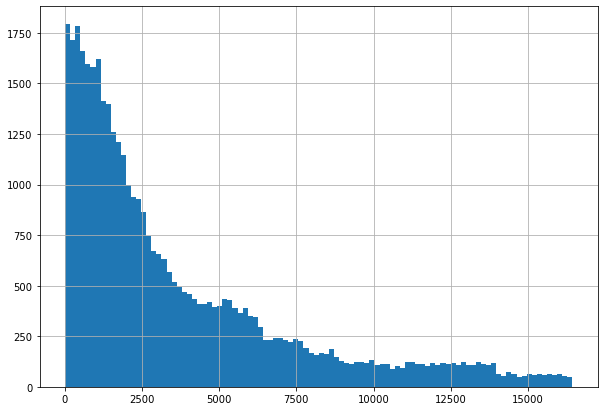

In [25]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)
display(df_train['Ranking'].describe())

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

Всего городов: 31
Процент пропусков 0.0%


<AxesSubplot:>

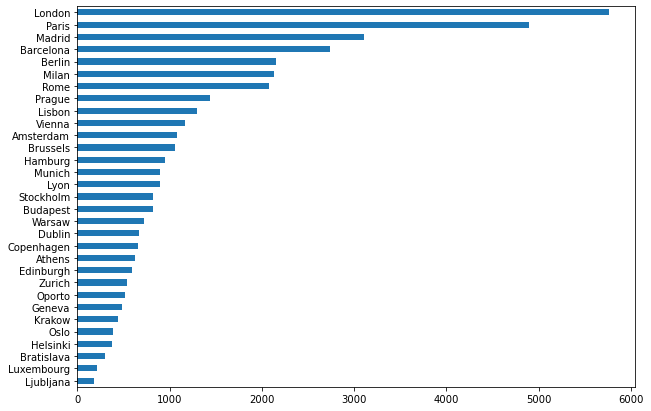

In [26]:
print(f'Всего городов: {len(df_train["City"].value_counts())}')
print(f'Процент пропусков {round(len(df_train[df_train["City"].isna()]) / 395 * 100, 2)}%')
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

<AxesSubplot:>

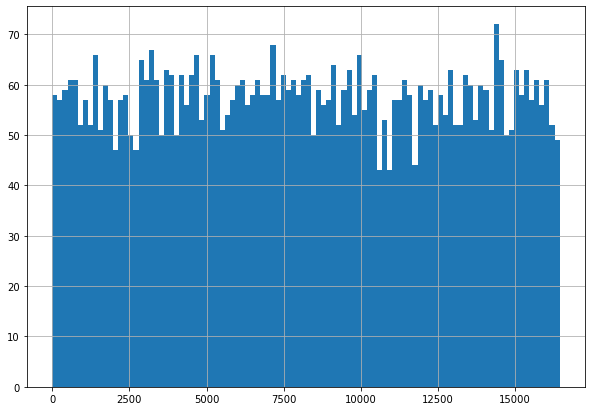

In [27]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

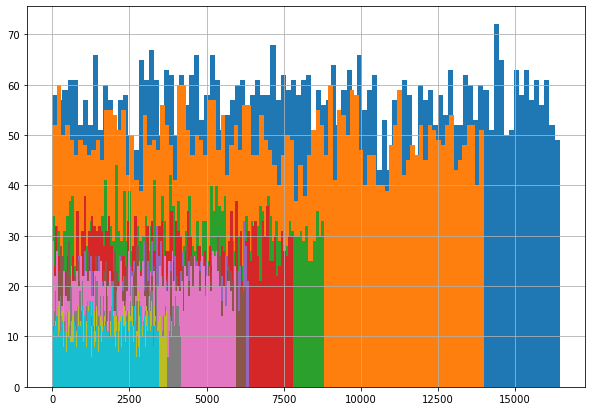

In [28]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

### Посмотрим распределение целевой переменной

count    40000.000000
mean         3.993037
std          0.668417
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: Rating, dtype: float64

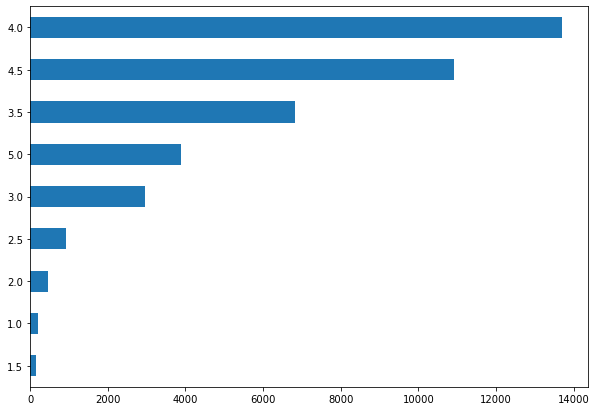

In [29]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')
display(df_train['Rating'].describe())

1. Целевая переменная меняется от 1 до 5 с шагом 0.5.
2. Выбросов и пропусков нет
3. Наиболее часто встречающийся рейтинг - 4
4. Высоких рейтингов больше, чем низких

### Посмотрим распределение целевой переменной относительно признака

<AxesSubplot:>

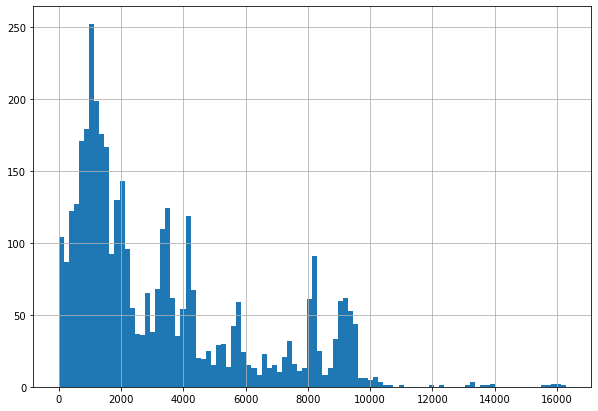

In [30]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

<AxesSubplot:>

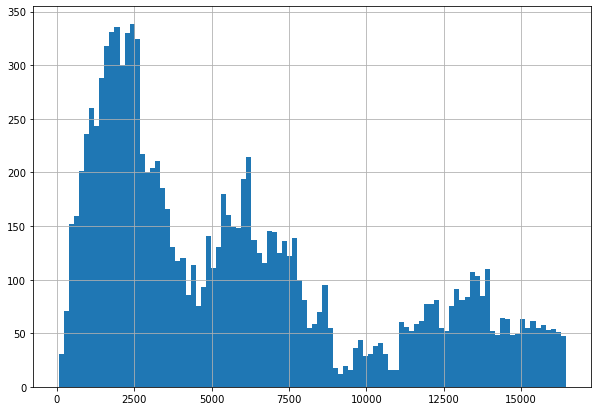

In [31]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### Признак Number_of_Reviews

count    37457.000000
mean       124.825480
std        295.666352
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

<AxesSubplot:>

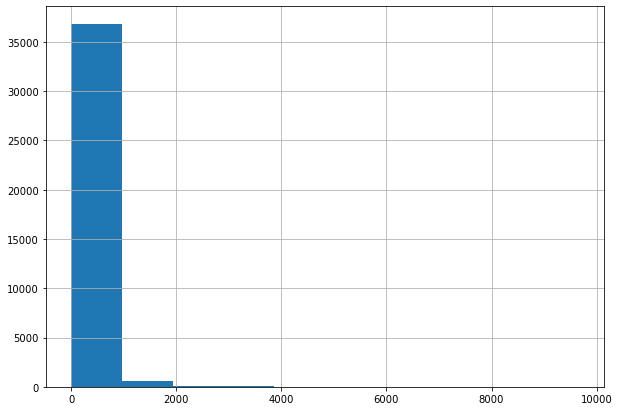

In [32]:
display(df_train['Number of Reviews'].describe())
df_train['Number of Reviews'].hist()

<AxesSubplot:>

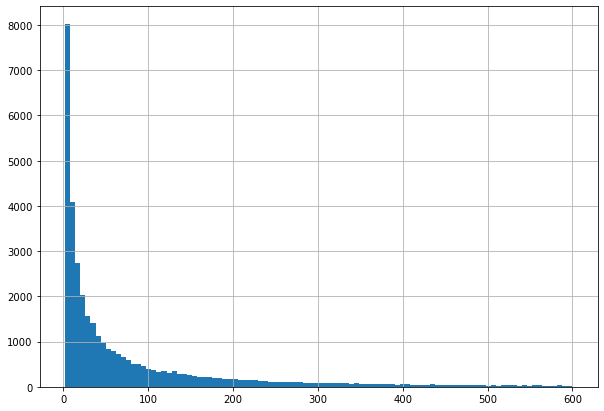

In [33]:
# Заполним пропуски 0. Будем считать что значения отсутствуют, потому что нет отзывов
data['Number of Reviews'].fillna(0, inplace=True)
# Посмотрим поближе 
df_train['Number of Reviews'][df_train['Number of Reviews'] <=600].hist(bins=100)

1. У большинства ресторанов отзывов меньше 50
2. Достаточно большие значения (больше 4000), которые встречаются редко, для модели лучше не считать выбросами.
3. При заполнении пропусков другими значениями модель показывала результаты хуже

### Признак Price Range

count    40000.000000
mean         1.878600
std          0.421683
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: Price Range, dtype: float64

<AxesSubplot:>

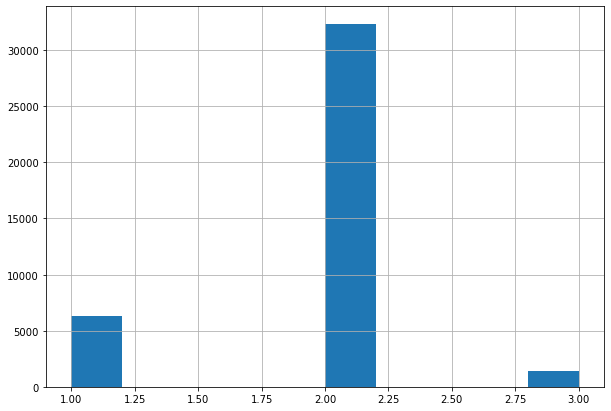

In [34]:
display(df_train['Price Range'].describe())
df_train['Price Range'].hist()

<AxesSubplot:>

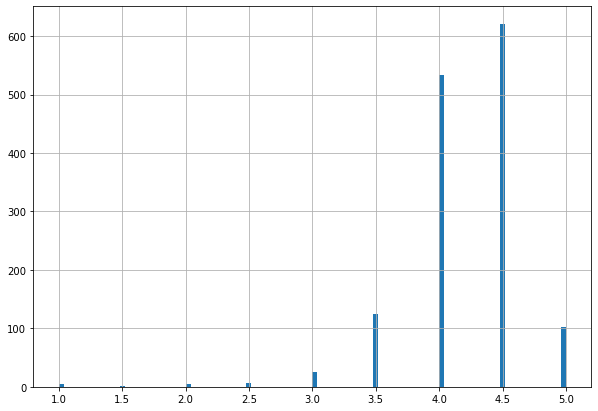

In [35]:
# Посмотрим рейтинги ресторанов с высоким ценником
df_train['Rating'][df_train['Price Range'] == 3].hist(bins=100)

<AxesSubplot:>

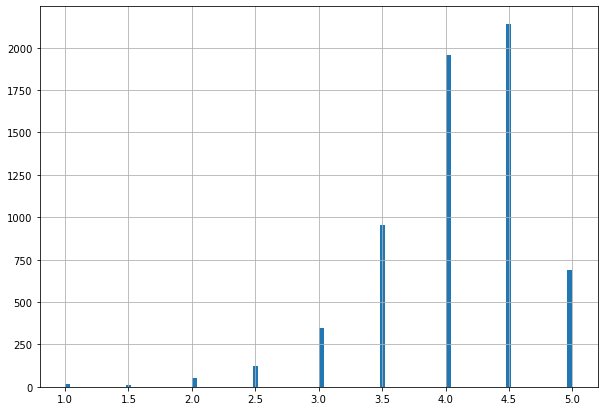

In [36]:
# А теперь с низким
df_train['Rating'][df_train['Price Range'] == 1].hist(bins=100)

<AxesSubplot:>

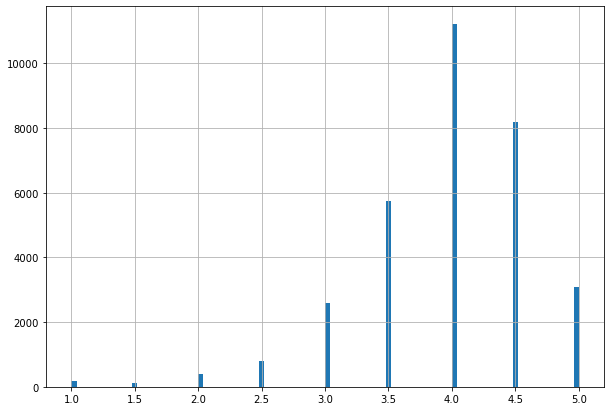

In [37]:
# И наконец, с самым часто встречающимся - средним ценником
df_train['Rating'][df_train['Price Range'] == 2].hist(bins=100)

1. Пропуски мы заполнили заранее средними ценами. 
2. Подавлеющее большинство ресторанов выставляют средние ценники. 
3. Удивительно, что у ресторанов с высокими и низкими ценами, примерно одинаковое распределение рейтинга и самая частая оценка это 4.5, а у ресторанов со средним ценником (как и у большинства ресторанов) - самый частый рейтинг 4.

### Признак Cuisine Style

In [38]:
c = Counter()
for styles in df_train['Cuisine Style']:
    for style in styles:
        c[style] +=1
print(f'Всего представлено {len(c)} видов кухни, включая тип "Unknown"')
c.most_common()

Всего представлено 126 видов кухни, включая тип "Unknown"


[('Vegetarian Friendly', 11189),
 ('European', 10060),
 ('Unknown', 9283),
 ('Mediterranean', 6277),
 ('Italian', 5964),
 ('Vegan Options', 4486),
 ('Gluten Free Options', 4113),
 ('Bar', 3297),
 ('French', 3190),
 ('Asian', 3011),
 ('Pizza', 2849),
 ('Spanish', 2798),
 ('Pub', 2449),
 ('Cafe', 2325),
 ('Fast Food', 1705),
 ('British', 1595),
 ('International', 1584),
 ('Seafood', 1505),
 ('Japanese', 1464),
 ('Central European', 1393),
 ('American', 1315),
 ('Sushi', 1156),
 ('Chinese', 1145),
 ('Portuguese', 1107),
 ('Indian', 1041),
 ('Middle Eastern', 782),
 ('Thai', 743),
 ('Wine Bar', 697),
 ('German', 662),
 ('Healthy', 620),
 ('Greek', 604),
 ('Halal', 598),
 ('Czech', 595),
 ('Fusion', 577),
 ('Steakhouse', 573),
 ('Barbecue', 555),
 ('Contemporary', 523),
 ('Vietnamese', 513),
 ('Eastern European', 496),
 ('Soups', 494),
 ('Grill', 490),
 ('Gastropub', 471),
 ('Mexican', 445),
 ('Turkish', 444),
 ('Delicatessen', 392),
 ('Austrian', 380),
 ('South American', 372),
 ('Polish',

Самые популярные кухни это - Vegetarian Friendly, European и значения Unknown, которыми мы заменили пропуски.

## Создание новых признаков
Попробуем перевести id ресторана в числовой формат и посмотрим что из этого получится.

In [39]:
data['rest_id'] = data['Restaurant_id'].apply(lambda x: int(x[3:]))

Добавим датасет с информацией о городах, в которых находятся рестораны. Сразу проверим, чтобы все города были в датасете.

In [40]:
df_city = pd.read_csv('worldcities.csv')

for city in data['City'].unique():
    if city not in df_city['city_ascii'].unique():
        print(f'Город, которого не хватает в датасете: {city}')

Город, которого не хватает в датасете: Oporto


Поискав информацию по этому городу выясняется, что в некоторых источниках он пишется как Porto. Заменим название на Oporto, которое встречается в датасете с ресторанами. И посмотрим на информацию о городах, которые нам нужны.

In [41]:
df_city['city_ascii'].loc[df_city['city_ascii'] == 'Porto'] = 'Oporto'
for city in data['City'].unique():
    display(df_city[df_city['city_ascii'] == city])  

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
33,Paris,Paris,48.8566,2.3522,France,FR,FRA,Île-de-France,primary,11020000.0,1250015082
13940,Paris,Paris,33.6688,-95.5460,United States,US,USA,Texas,NaN,26010.0,1840020594
18656,Paris,Paris,38.2016,-84.2719,United States,US,USA,Kentucky,NaN,12485.0,1840014315
19969,Paris,Paris,36.2934,-88.3065,United States,US,USA,Tennessee,NaN,10536.0,1840014438
21764,Paris,Paris,39.6149,-87.6904,United States,US,USA,Illinois,NaN,8394.0,1840009542
25704,Paris,Paris,44.2445,-70.4883,United States,US,USA,Maine,NaN,5131.0,1840052952


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
741,Helsinki,Helsinki,60.1756,24.9342,Finland,FI,FIN,Uusimaa,primary,642045.0,1246177997


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
1395,Edinburgh,Edinburgh,55.953,-3.189,United Kingdom,GB,GBR,"Edinburgh, City of",NaN,488050.0,1826492520


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
34,London,London,51.5072,-0.1275,United Kingdom,GB,GBR,"London, City of",primary,10979000.0,1826645935
1669,London,London,42.9836,-81.2497,Canada,CA,CAN,Ontario,NaN,383822.0,1124469960
12232,London,London,37.1175,-84.0767,United States,US,USA,Kentucky,NaN,37714.0,1840015258
17408,London,London,39.8936,-83.4376,United States,US,USA,Ohio,NaN,14870.0,1840000674


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
752,Bratislava,Bratislava,48.1447,17.1128,Slovakia,SK,SVK,Bratislavský,primary,429564.0,1703195001


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
748,Lisbon,Lisbon,38.7452,-9.1604,Portugal,PT,PRT,Lisboa,primary,506654.0,1620619017
21266,Lisbon,Lisbon,44.0265,-70.0900,United States,US,USA,Maine,NaN,8896.0,1840066320
25367,Lisbon,Lisbon,40.7752,-80.7628,United States,US,USA,Ohio,NaN,5372.0,1840011932


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
429,Budapest,Budapest,47.4983,19.0408,Hungary,HU,HUN,Budapest,primary,1752286.0,1348611435


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
717,Stockholm,Stockholm,59.3294,18.0686,Sweden,SE,SWE,Stockholm,primary,972647.0,1752425602


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
280,Rome,Rome,41.8931,12.4828,Italy,IT,ITA,Lazio,primary,2872800.0,1380382862
10584,Rome,Rome,34.2661,-85.1862,United States,US,USA,Georgia,NaN,61537.0,1840014681
12920,Rome,Rome,43.2260,-75.4909,United States,US,USA,New York,NaN,31863.0,1840000349


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
536,Milan,Milan,45.4669,9.1900,Italy,IT,ITA,Lombardy,admin,1351562.0,1380724377
22380,Milan,Milan,42.0816,-83.6853,United States,US,USA,Michigan,NaN,7778.0,1840003170
23057,Milan,Milan,35.9126,-88.7554,United States,US,USA,Tennessee,NaN,7201.0,1840014483


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
498,Munich,Munich,48.1372,11.5755,Germany,DE,DEU,Bavaria,admin,1471508.0,1276692352


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
410,Hamburg,Hamburg,53.5500,10.0000,Germany,DE,DEU,Hamburg,admin,1841179.0,1276041799
10740,Hamburg,Hamburg,42.7394,-78.8581,United States,US,USA,New York,NaN,58105.0,1840004385


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
545,Prague,Prague,50.0833,14.4167,Czechia,CZ,CZE,"Praha, Hlavní Město",primary,1324277.0,1203744823


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
408,Vienna,Vienna,48.2083,16.3731,Austria,AT,AUT,Wien,primary,1840573.0,1040261752
16727,Vienna,Vienna,38.8996,-77.2597,United States,US,USA,Virginia,NaN,16485.0,1840003829
20286,Vienna,Vienna,39.3240,-81.5383,United States,US,USA,West Virginia,NaN,10124.0,1840005787
25343,Vienna,Vienna,43.2344,-75.7777,United States,US,USA,New York,NaN,5390.0,1840058566


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
601,Dublin,Dublin,53.3425,-6.2658,Ireland,IE,IRL,Dublin,primary,1173179.0,1372595407
10425,Dublin,Dublin,37.7161,-121.8963,United States,US,USA,California,NaN,64826.0,1840018916
11264,Dublin,Dublin,40.1112,-83.1454,United States,US,USA,Ohio,NaN,49037.0,1840008389
15305,Dublin,Dublin,32.5359,-82.9280,United States,US,USA,Georgia,NaN,20583.0,1840013813


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
163,Barcelona,Barcelona,41.3825,2.1769,Spain,ES,ESP,Catalonia,admin,4588000.0,1724594040
1492,Barcelona,Barcelona,10.1333,-64.6833,Venezuela,VE,VEN,Anzoátegui,admin,448016.0,1862418619


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
780,Brussels,Brussels,50.8467,4.3517,Belgium,BE,BEL,Brussels-Capital Region,primary,185103.0,1056469830


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
238,Madrid,Madrid,40.4189,-3.6919,Spain,ES,ESP,Madrid,primary,3266126.0,1724616994


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
737,Oslo,Oslo,59.9111,10.7528,Norway,NO,NOR,Oslo,primary,693494.0,1578324706


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
685,Amsterdam,Amsterdam,52.350,4.9166,Netherlands,NL,NLD,Noord-Holland,primary,1031000.0,1528355309
15113,Amsterdam,Amsterdam,42.942,-74.1907,United States,US,USA,New York,NaN,21241.0,1840000391


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
215,Berlin,Berlin,52.5167,13.3833,Germany,DE,DEU,Berlin,primary,3644826.0,1276451290
15326,Berlin,Berlin,41.6114,-72.7758,United States,US,USA,Connecticut,NaN,20519.0,1840034026
19503,Berlin,Berlin,44.4869,-71.2599,United States,US,USA,New Hampshire,NaN,11237.0,1840002100
22640,Berlin,Berlin,39.7915,-74.9375,United States,US,USA,New Jersey,NaN,7536.0,1840001505


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
1309,Lyon,Lyon,45.76,4.84,France,FR,FRA,Auvergne-Rhône-Alpes,admin,516092.0,1250196189


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
739,Athens,Athens,37.9794,23.7161,Greece,GR,GRC,Attikí,primary,664046.0,1300715560
3554,Athens,Athens,33.9508,-83.3689,United States,US,USA,Georgia,NaN,141532.0,1840029463
13014,Athens,Athens,34.7847,-86.9510,United States,US,USA,Alabama,NaN,31187.0,1840000935
13341,Athens,Athens,39.3269,-82.0988,United States,US,USA,Ohio,NaN,29122.0,1840007355
16656,Athens,Athens,35.4573,-84.6045,United States,US,USA,Tennessee,NaN,16651.0,1840013429
18829,Athens,Athens,32.2041,-95.8321,United States,US,USA,Texas,NaN,12210.0,1840019500


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
422,Warsaw,Warsaw,52.2167,21.0333,Poland,PL,POL,Mazowieckie,primary,1790658.0,1616024847
12691,Warsaw,Warsaw,41.2448,-85.8464,United States,US,USA,Indiana,NaN,33708.0,1840010277


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
2343,Porto,Oporto,41.1495,-8.6108,Portugal,PT,PRT,Porto,admin,237591.0,1620356810


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
984,Kraków,Krakow,50.0614,19.9372,Poland,PL,POL,Małopolskie,admin,766739.0,1616172264


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
651,Copenhagen,Copenhagen,55.6786,12.5635,Denmark,DK,DNK,Hovedstaden,primary,1085000.0,1208763942


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
789,Luxembourg,Luxembourg,49.6106,6.1328,Luxembourg,LU,LUX,Luxembourg,primary,122273.0,1442262731


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
1516,Zürich,Zurich,47.3786,8.54,Switzerland,CH,CHE,Zürich,admin,434008.0,1756539143


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
2585,Geneva,Geneva,46.2000,6.1500,Switzerland,CH,CHE,Genève,admin,201818.0,1756810813
13432,Geneva,Geneva,42.8644,-76.9827,United States,US,USA,New York,NaN,28563.0,1840000393
14957,Geneva,Geneva,41.8832,-88.3242,United States,US,USA,Illinois,NaN,21809.0,1840008135
22928,Geneva,Geneva,41.8006,-80.9461,United States,US,USA,Ohio,NaN,7317.0,1840008145


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
770,Ljubljana,Ljubljana,46.05,14.5167,Slovenia,SI,SVN,Ljubljana,primary,284355.0,1705917455


Мы видим, что некоторые названия городов повторяются в разных странах. Удалим ненужные строки

In [42]:
df_city = df_city[df_city['city_ascii'].isin(data['City'].unique())]
df_city = df_city[~df_city['country'].isin(['United States', 'Canada', 'Venezuela'])]

In [43]:
df_city.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 33 to 2585
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        31 non-null     object 
 1   city_ascii  31 non-null     object 
 2   lat         31 non-null     float64
 3   lng         31 non-null     float64
 4   country     31 non-null     object 
 5   iso2        31 non-null     object 
 6   iso3        31 non-null     object 
 7   admin_name  31 non-null     object 
 8   capital     30 non-null     object 
 9   population  31 non-null     float64
 10  id          31 non-null     int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 2.9+ KB


In [44]:
df_city.sample(5)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
422,Warsaw,Warsaw,52.2167,21.0333,Poland,PL,POL,Mazowieckie,primary,1790658.0,1616024847
410,Hamburg,Hamburg,53.5500,10.0000,Germany,DE,DEU,Hamburg,admin,1841179.0,1276041799
408,Vienna,Vienna,48.2083,16.3731,Austria,AT,AUT,Wien,primary,1840573.0,1040261752
2343,Porto,Oporto,41.1495,-8.6108,Portugal,PT,PRT,Porto,admin,237591.0,1620356810
429,Budapest,Budapest,47.4983,19.0408,Hungary,HU,HUN,Budapest,primary,1752286.0,1348611435


Удалим столбцы, которые не пригодятся нам для работы и объединим датасеты.

In [45]:
df_city.drop(['city','iso2', 'iso3', 'admin_name', 'capital', 'country'], axis = 1, inplace=True)
data = data.merge(df_city, left_on = 'City', right_on = 'city_ascii', how = 'left' )
data.drop(['city_ascii'], axis = 1, inplace=True)
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine Style_isNAN,Price Range_isNAN,Number of Reviews_isNAN,Reviews_isNAN,only_reviews,date_reviews,rest_id,lat,lng,population,id
39323,id_1208,Paris,"[French, Bar, European, Vegetarian Friendly, V...",1209.0,2,265.0,"[['Very good', 'Great for a quick stop'], ['10...",/Restaurant_Review-g187147-d6570661-Reviews-Ca...,d6570661,1,4.0,0,0,0,0,"'Very good', 'Great for a quick stop","[2017-10-26 00:00:00, 2017-09-09 00:00:00]",1208,48.8566,2.3522,11020000.0,1250015082
36271,id_2348,Budapest,"[European, Central European, Hungarian]",2349.0,2,40.0,"[['Horrible service, mediocre food - and a do....",/Restaurant_Review-g274887-d4942754-Reviews-Ma...,d4942754,1,2.5,0,0,0,0,"'Horrible service, mediocre food - and a do......","[2017-09-17 00:00:00, 2017-07-22 00:00:00]",2348,47.4983,19.0408,1752286.0,1348611435
47429,id_6217,Paris,[Chinese],6218.0,1,16.0,"[['Okishhh', 'Gastronomie délicieuse'], ['10/1...",/Restaurant_Review-g187147-d7930453-Reviews-Ma...,d7930453,1,4.0,0,0,0,0,"'Okishhh', 'Gastronomie délicieuse","[2017-10-18 00:00:00, 2017-05-26 00:00:00]",6217,48.8566,2.3522,11020000.0,1250015082
4644,id_4644,Berlin,"[Mediterranean, European, Spanish, Vegetarian ...",2553.0,2,145.0,"[['Chorizo to die for', 'Neighborhood tapas pl...",/Restaurant_Review-g187323-d1085381-Reviews-Re...,d1085381,0,0.0,0,0,0,0,"'Chorizo to die for', 'Neighborhood tapas place","[2017-12-31 00:00:00, 2017-11-05 00:00:00]",4644,52.5167,13.3833,3644826.0,1276451290
23819,id_2299,Barcelona,"[Bar, Mediterranean, European, Spanish, Vegeta...",2300.0,2,124.0,"[['Bad service, bad food', 'Authentic mediterr...",/Restaurant_Review-g187497-d6367223-Reviews-Ba...,d6367223,1,4.0,0,0,0,0,"'Bad service, bad food', 'Authentic mediterran...","[2017-11-30 00:00:00, 2017-06-23 00:00:00]",2299,41.3825,2.1769,4588000.0,1724594040


Описание новых столбцов:

1. lat - широта, на которой расположен город
2. lng - долгота, на которой расположен город
3. population - население города
4. id - идентификационный номер города

Признак сountry (cтрана), выраженный через dummy-переменные, не принес пользы модели
Признак capital (административное значение города), выраженный через dummy-переменные и как категориальный признак, также не принес никаких улучшений

Добавим столбец с информацией о количестве кухонь предлагаемых в ресторане

In [46]:
data['count_cuis_style'] = data['Cuisine Style'].apply(lambda x: len(x))

Добавим информацию о максимальном ранке ресторана в городе(будем считать что именно столько ресторанов находится в городе). Также посчитаем отношение ранга ресторана к количеству ресторанов в городе.

In [47]:
rank_max = data.groupby(['City'])['Ranking'].max()
ranking_max = data['City'].apply(lambda x: rank_max[x])
data['rank_per_max'] = data['Ranking'] / ranking_max

Посчитаем средний ценник в ресторанах по городам и добавим столбец с отношением количества ресторанов к среднему ценнику в городе

In [48]:
prices_in_city = data.groupby(['City'])['Price Range'].mean()
mean_price = data['City'].apply(lambda x: prices_in_city[x])
data['mean_price_vs_rank'] = ranking_max / mean_price

Добавим столбцы с информацией по количеству отзывов во всем городе и отношении ранга ресторана к общему количеству отзывов в городе

In [49]:
cities_reviews = data.groupby(['City'])['Number of Reviews'].sum()
data['reviews_in_city'] = data['City'].apply(lambda x: cities_reviews[x])
data['rank_vs_reviews'] = data['Ranking'] / data['reviews_in_city']

Добавим с толбец с отношением количества отзывов ресторана к населению в городе

In [50]:
data['pop_vs_rev'] = data['Number of Reviews'] / data['population'] 

Добавим столбцы с информацией с разницей между отзывами (в днях), а также с разницей с текущей датой

In [51]:
data['timedelta_rev'] = data['date_reviews'].apply(reviews_timedelta)
data['timedelta_for_now'] = data['date_reviews'].apply(timedelta_rev_now)

Так же из признака Reviews можно взять информацию по тональности и субъективности отзыва. Она будет варьироваться от -1 до 1. Чем меньше оценка, тем негативнее и менее субъективен отзыв.

In [52]:
data['review_mood']= data['only_reviews'].apply(lambda x: TextBlob(x).sentiment[0])
data['review_sub'] = data['only_reviews'].apply(lambda x: TextBlob(x).sentiment[1])   

Несколько столбцов полученных перемножением, которые улучшили модель

In [53]:
data['rank_vs_rev'] = data['pop_vs_rev'] * data['rank_per_max']
data['price*mood*rank'] = data['Price Range'] * data['review_mood'] * data['rank_per_max'] 

## Корреляция признаков

<AxesSubplot:>

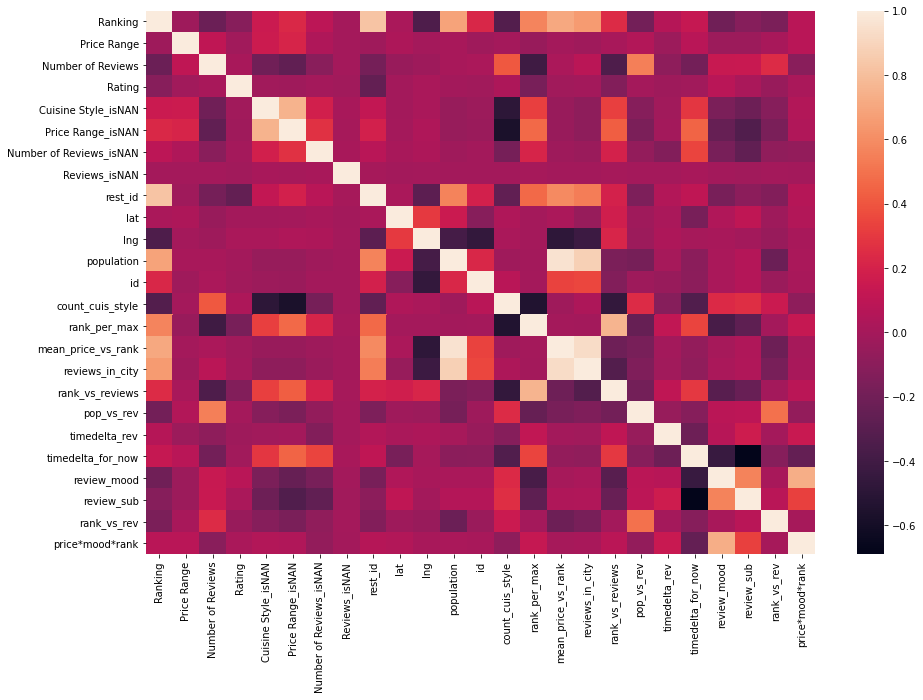

In [54]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Мы видим, что некоторые признаки сильно скоррелированы между собой, но при их удалении модель показывает результаты хуже, поэтому стоит их оставить(кроме признака 'lng').

## Data Preprocessing
На всякий случай копируем наш Датафрейм и удаляем все ненужные признаки

In [55]:
df_preproc = data.copy()
df_preproc.drop(['lng'], axis = 1, inplace=True)
object_columns = [s for s in df_preproc.columns if df_preproc[s].dtypes == 'object']
df_preproc.drop(object_columns, axis = 1, inplace=True)
df_preproc.sample(5)

,Ranking,Price Range,Number of Reviews,sample,Rating,Cuisine Style_isNAN,Price Range_isNAN,Number of Reviews_isNAN,Reviews_isNAN,rest_id,lat,population,id,count_cuis_style,rank_per_max,mean_price_vs_rank,reviews_in_city,rank_vs_reviews,pop_vs_rev,timedelta_rev,timedelta_for_now,review_mood,review_sub,rank_vs_rev,price*mood*rank
47307,1070.0,1,14.0,1,4.5,0,0,0,0,1069,48.2083,1840573.0,1040261752,2,0.310685,1798.657980,106709.0,0.010027,0.000008,11,1285,0.478125,0.8125,0.000002,0.148546
6835,160.0,3,258.0,0,0.0,0,0,0,0,6835,60.1756,642045.0,1246177997,4,0.140228,596.888767,29511.0,0.005422,0.000402,3,1153,0.000000,0.0000,0.000056,0.000000
27284,1213.0,2,46.0,1,4.0,0,0,0,0,1212,48.2083,1840573.0,1040261752,2,0.352207,1798.657980,106709.0,0.011367,0.000025,0,2595,1.000000,1.0000,0.000009,0.704413
11885,740.0,2,322.0,1,4.0,0,0,0,0,739,40.4189,3266126.0,1724616994,4,0.084005,4597.415412,357185.0,0.002072,0.000099,25,1233,0.325000,0.3000,0.000008,0.054603
20597,1509.0,2,20.0,1,3.5,0,0,0,0,1508,47.4983,1752286.0,1348611435,1,0.618443,1350.265583,148366.0,0.010171,0.000011,16,1216,0.550000,0.6000,0.000007,0.680287


In [56]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ranking                  50000 non-null  float64
 1   Price Range              50000 non-null  int64  
 2   Number of Reviews        50000 non-null  float64
 3   sample                   50000 non-null  int64  
 4   Rating                   50000 non-null  float64
 5   Cuisine Style_isNAN      50000 non-null  uint8  
 6   Price Range_isNAN        50000 non-null  uint8  
 7   Number of Reviews_isNAN  50000 non-null  uint8  
 8   Reviews_isNAN            50000 non-null  uint8  
 9   rest_id                  50000 non-null  int64  
 10  lat                      50000 non-null  float64
 11  population               50000 non-null  float64
 12  id                       50000 non-null  int64  
 13  count_cuis_style         50000 non-null  int64  
 14  rank_per_max          

In [57]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [58]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [59]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 24), (40000, 24), (40000, 23), (32000, 23), (8000, 23))

# Model 
Сам ML

In [60]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [61]:
# Создаём модель 
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [62]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [63]:
y_pred = round_of_rating(y_pred)

In [64]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1656875


<AxesSubplot:>

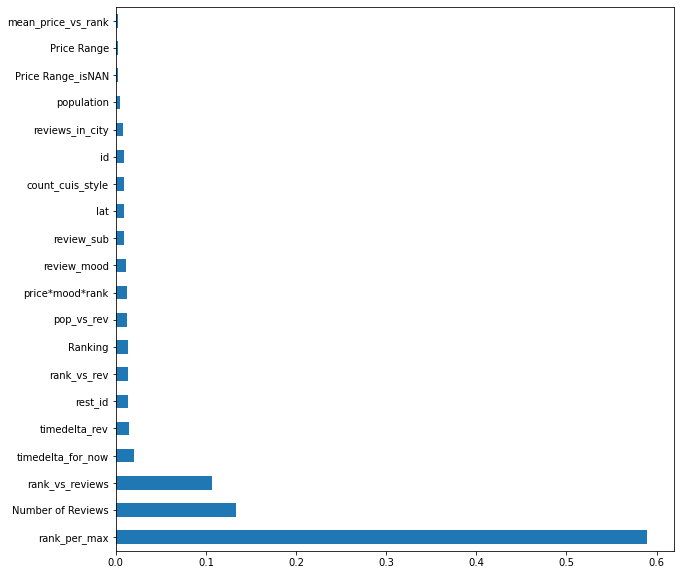

In [65]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Submission

In [66]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Cuisine Style_isNAN,Price Range_isNAN,Number of Reviews_isNAN,Reviews_isNAN,rest_id,lat,population,id,count_cuis_style,rank_per_max,mean_price_vs_rank,reviews_in_city,rank_vs_reviews,pop_vs_rev,timedelta_rev,timedelta_for_now,review_mood,review_sub,rank_vs_rev,price*mood*rank
6928,360.0,1,116.0,0.0,0,0,0,0,6928,52.3500,1031000.0,1528355309,5,0.110633,1738.507788,193814.0,0.001857,0.000113,0,1154,1.000000,0.300000,1.244756e-05,0.110633
5324,1759.0,2,19.0,0.0,0,0,0,0,5324,55.6786,1085000.0,1208763942,2,0.895621,1015.477273,73670.0,0.023877,0.000018,489,1518,-1.000000,1.000000,1.568369e-05,-1.791242
4013,3947.0,3,33.0,0.0,0,0,0,0,4013,41.8931,2872800.0,1380382862,2,0.663584,3325.280069,728235.0,0.005420,0.000011,6,1152,0.800000,0.833333,7.622628e-06,1.592603
6235,309.0,2,56.0,0.0,0,0,0,0,6235,48.2083,1840573.0,1040261752,1,0.089721,1798.657980,106709.0,0.002896,0.000030,13,1252,0.800000,0.825000,2.729797e-06,0.143554
9651,2053.0,2,0.0,0.0,1,1,1,0,9651,53.5500,1841179.0,1276041799,1,0.750091,1410.726641,48853.0,0.042024,0.000000,0,7734,0.000000,0.000000,0.000000e+00,0.000000
9577,2818.0,1,49.0,0.0,0,0,0,0,9577,51.5072,10979000.0,1826645935,3,0.171369,8831.605466,933770.0,0.003018,0.000004,29,1279,0.625000,0.612500,7.648333e-07,0.107106
8785,5.0,3,771.0,0.0,0,0,0,0,8785,53.3425,1173179.0,1372595407,7,0.002551,1065.383615,122804.0,0.000041,0.000657,2,1154,0.160000,0.540000,1.676502e-06,0.001224
4420,2920.0,2,102.0,0.0,0,0,0,0,4420,48.8566,11020000.0,1250015082,4,0.208780,7257.985387,680827.0,0.004289,0.000009,51,1400,0.750000,0.675000,1.932448e-06,0.313170
3448,7021.0,1,38.0,0.0,0,0,0,0,3448,51.5072,10979000.0,1826645935,2,0.426964,8831.605466,933770.0,0.007519,0.000003,70,1162,0.502778,0.638889,1.477789e-06,0.214668
6319,3083.0,1,9.0,0.0,0,0,0,0,6319,45.4669,1351562.0,1380724377,2,0.491315,3400.010056,431350.0,0.007147,0.000007,0,7734,0.000000,0.000000,3.271646e-06,0.000000


In [67]:
test_data = test_data.drop(['Rating'], axis=1)

In [68]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [69]:
predict_submission = round_of_rating(model.predict(test_data))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [70]:
predict_submission

array([3.5, 4. , 4.5, ..., 3. , 4.5, 4.5])

In [71]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.5
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5
